# Regularised Linear Regression
### Advance regression techniques
Author: Akshay Gautam ([Github](https://github.com/Ak-Gautam/)), ([twitter](https://twitter.com/Gautam_A_k)), ([linkedIn](https://www.linkedin.com/in/akshay-kumar-gautam-880b361a5))

<b>This notebook is written in a way to make different concepts easier to understand. You can follow this project if you know the basics of ML and want to have some more firm experience.</b>

<hr>
- You are welcome to directly use parts or in full of this project in your own but some kid of credit to original Author would be recommended (Like a link back to this project).
- You are welcome to try to bring down the RMSE even more (making the predictions more accurate).
- Please feel free to correct any spelling mistakes (create a pull req)

<i>Let's begin..!!!</i>

We will import most of the libraries without thinking much.

### This dataset given has 80 features and there are a lot of skewed values.

This is mostly going to be about playing with the data.

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib

In [2]:
#plt.style.available
#for available different backgrounds for the plots

In [3]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from scipy import stats

In [4]:
%config InlineBackend.figure_format = 'png'
%matplotlib inline

In [5]:
train = pd.read_csv("dataSet/train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
test = pd.read_csv("dataSet/test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


We are here combining all the data except 'Id' and 'SalePrice' as Id is irrelevant and test data doesn't contains SalePrice.

## Visualization

some heatmaps to understand the correlation between data points.

<AxesSubplot:>

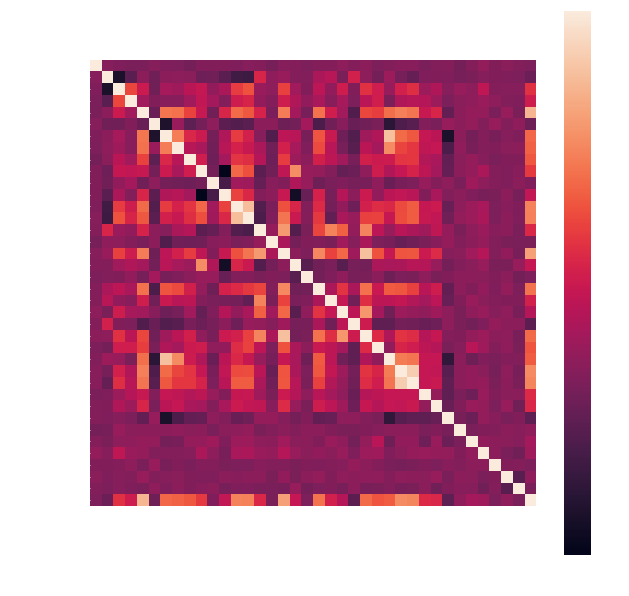

In [7]:
Rmat = train.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(Rmat, vmax = 1, square = True)

#The plot will appear ugly if you're using light theme

We need to select features with strong correlation with SalePrice because that's what we will need to predict.<br>
<b>Looking at the chart above it's kinda clear thst lots of features in the dataset is just confusing.

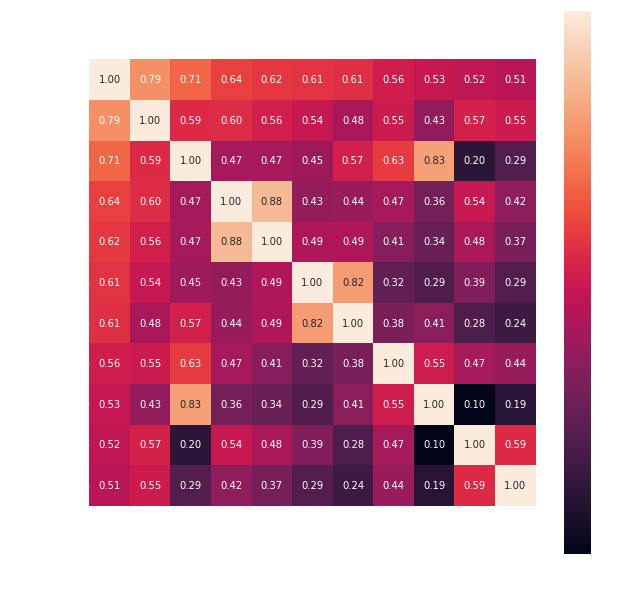

In [8]:
#To plot SalePrice correlation matrix
v = 11 #no. of variable for the heatmap
cols = Rmat.nlargest(v, 'SalePrice')['SalePrice'].index
# We are selecting the v columns of the matrix with largest correlation
# with SalePrice (I love python for these little tricks)
cm = np.corrcoef(train[cols].values.T)
# Here we are accessing the correlation coefficients to present as numbers
f1, ax1 = plt.subplots(figsize = (10, 10))
sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)

plt.show()

#### So much better
So now we have the top 10 features with highest correlation with the SalePrice with coefficients represented as numbers.<br><hr>
<i>The strongest correlation between any two variables in this dataset is the correlation between 'GarageCars' and GarageArea', as these are obviously expressions of the same property in different units and with different rounding methods. These variables are not independent. Having such a correlation between two variables that are used for the predicition of a third variable could lead to a model that focuses too much on this property.</i><br><b><hr>To avoid overfitting, we set an arbirary cut off here and decide that we will not use variables in the model that have a correlation coefficient of over 0.8 with another variable in the model. Thus, We need to exclude at least three of the variables that are listed in the figure above. We will first look at the description of the variables, the missing data, the ranges of data, and the outliers. Then, we will decide which to exclude.</b>

## Data preprocessing

- we notice that not all the categorical variables have ranked categories like 'OverallQual'

In [9]:
all_null = train.isnull().sum().sort_values(ascending = False)
# sorted list of total missing number of elements

percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending = False)
# it's just in the ratio form, it has the same sorting order as above

missing_data = pd.concat([all_null, percent], axis = 1, keys = ['Total', 'Percent']) 
#combine to form a new dataframe

missing_data.loc[missing_data['Total']>0].head(len(train.columns))
# prints the whole frame except those features without missing data

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


<b> The above list does not contain the 10 variables that are correllated strongest with SalePrice. Thus, we do not have to exclude any of those variables on the ground of possible bias in the deletion of data.</b><br>If any of the features were common in both the assoertments, there was a chance of it creating a bias.<hr>
##### Many categorical variables do, however, miss data.
We have two ways now
- we can not include the missing data features
- we can fill the mean inplace of all the NaN values
<br><hr>
Before all that we load the test data to understand which range is relevant for each of the 10 variables that are correllated strongest with SalePrice.<br><b>The following table summarises the data that is missing in the test set:

In [10]:
all_null = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum()/test.isnull().count()).sort_values(ascending = False)

missing_data2 = pd.concat([all_null, percent], axis = 1, keys = ['Total', 'Percent']) 

missing_data2.loc[missing_data['Total']>0].head(len(train.columns))

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461
GarageCond,78,0.053461


Let's visulise some of the features with techniques.

### Bivariate analysis

There are variables in the train set that have missing values only in the test set. We ignore this for for now, and look at the ranges of the variables that correlate strongly with the SalePrice:

In [11]:
index_list  = list(Rmat.nlargest(v, 'SalePrice')['SalePrice'].index)

index_list.pop(0)
test[index_list].describe()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd
count,1459.000000,1459.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,6.078821,1486.045922,1.766118,472.768861,1046.117970,1156.534613,1.570939,6.385195,1971.357779,1983.662783
std,1.436812,485.566099,0.775945,217.048611,442.898624,398.165820,0.555190,1.508895,30.390071,21.130467
min,1.000000,407.000000,0.000000,0.000000,0.000000,407.000000,0.000000,3.000000,1879.000000,1950.000000
25%,5.000000,1117.500000,1.000000,318.000000,784.000000,873.500000,1.000000,5.000000,1953.000000,1963.000000
50%,6.000000,1432.000000,2.000000,480.000000,988.000000,1079.000000,2.000000,6.000000,1973.000000,1992.000000
75%,7.000000,1721.000000,2.000000,576.000000,1305.000000,1382.500000,2.000000,7.000000,2001.000000,2004.000000
max,10.000000,5095.000000,5.000000,1488.000000,5095.000000,5095.000000,4.000000,15.000000,2010.000000,2010.000000


All the features plotted against 'SalePrice' in a scatter plot

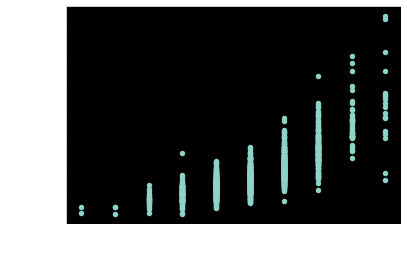

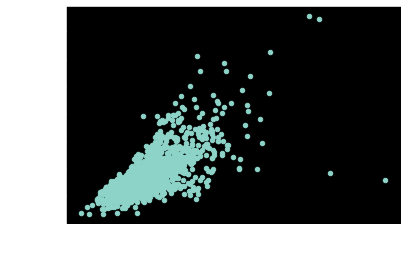

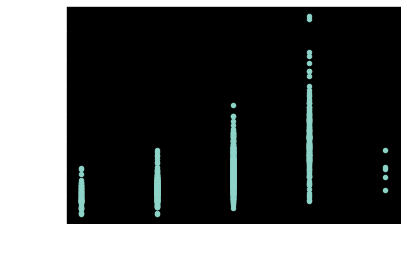

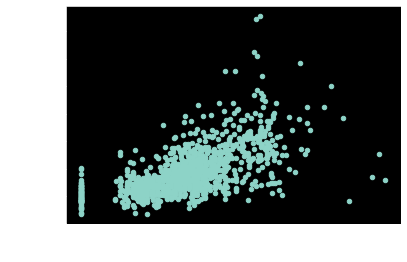

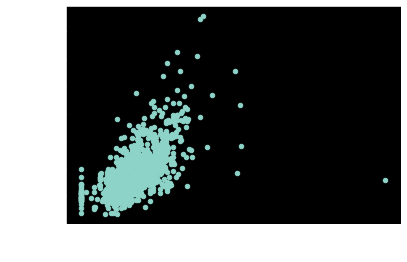

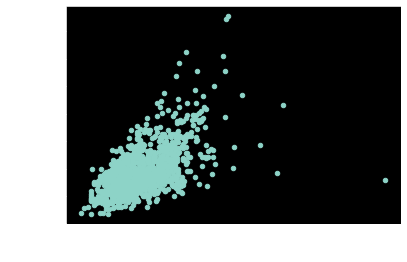

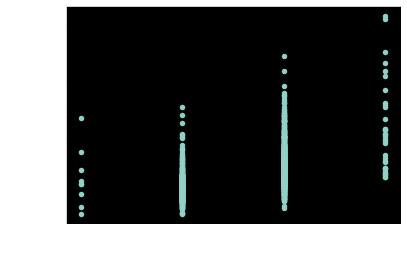

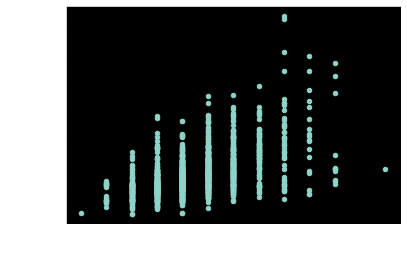

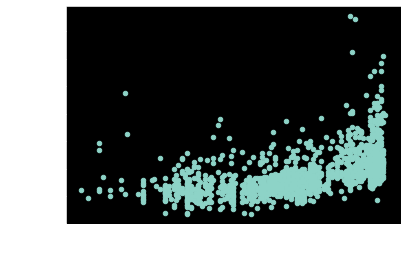

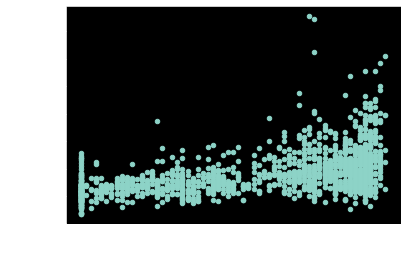

In [12]:
for var in index_list:
    data = pd.concat([train['SalePrice'], train[var]], axis=1)
    data.plot.scatter(x=var, y='SalePrice');

### Outliers
##### Some conclusions:
- The ranges of each variable in both sets overlap. This is an indication that they can be useful for prediction.
- One major concern about outliers is their effect on regression models. This effect strongly depends on the model and the metric for goodness of fit
- we should check whether our model is predicting the test data better, when we include the outliers in the training
<hr>
* We do, however, note that 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'TotRmsAbvGrd' contain data at the upper end of their ranges that could be outliers or manifestations of a non-monotonous impact of the size of a building on its SalePrice.

<b>There are suprisingly many houses build in 1900 and/or renovated in 1950. This may be a sign of unreliable data. Let's run a few tests to see whether the YearBuilt and YearRemodAdd data complements each other. Maybe, one of them just contains redundant data and wrong data.

In [13]:
print('Number of houses that were apparently remodelled in 1950:')
l=list(train['YearBuilt'].loc[train['YearRemodAdd']==1950])
print(len(l))
print('Number of houses that were apparently build in 1900:')
l=list(train['YearRemodAdd'].loc[train['YearBuilt']==1900])
print(len(l))
print('Number of houses that were apparently built in 1900 and remodelled in 1950:')
print(len([year for year in l if year==1950]))
print('Fraction of houses that were  remodelled:')
print(len(list(train['YearRemodAdd'].loc[train['YearBuilt']!=train['YearRemodAdd']]))/len(train['YearRemodAdd']))

Number of houses that were apparently remodelled in 1950:
178
Number of houses that were apparently build in 1900:
10
Number of houses that were apparently built in 1900 and remodelled in 1950:
5
Fraction of houses that were  remodelled:
0.4767123287671233


It seems that both YearRemodAdd and YearBuilt contain some helpful data.
- when the house was remodeled helps us in understanding the state of houses built in 1900
- when the house was built helps us understand the state of house remodeled in 1950
- for those houses that were remodelled both variables can be relevant for the SalePrice, and these make up about half of the data.<br>
Before deciding which variables to drop, we check whether a straight-forward combination of the all the variables that represent the indoor square feet has a stronger correlation than the individual variables. We do the same for the garage size:

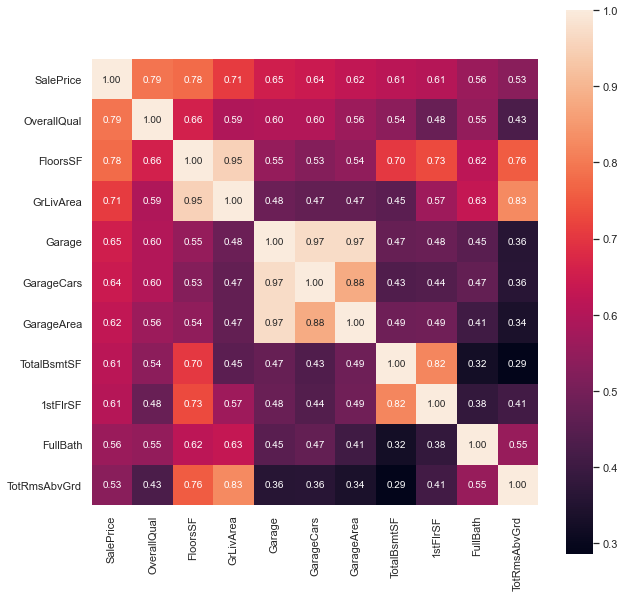

In [14]:
train['FloorsSF'] = pd.Series(len(train['YearBuilt']), index = train.index)
train['FloorsSF'] = train['1stFlrSF']+train['TotalBsmtSF']+train['2ndFlrSF']+train['GrLivArea']
medianG = train.loc[train['GarageCars']==1, 'GarageArea'].median()
train['Garage'] = pd.Series(len(train['YearBuilt']), index=train.index)
train['Garage'] = train['GarageCars']+1*train['GarageArea']/medianG
test['FloorsSF'] = pd.Series(len(test['YearBuilt']), index = test.index)
test['FloorsSF'] = test['1stFlrSF']+test['TotalBsmtSF']+test['2ndFlrSF']+test['GrLivArea']
medianG = test.loc[test['GarageCars']==1, 'GarageArea'].median()
test['Garage']=pd.Series(len(train['YearBuilt']), index=test.index)
test['Garage']=test['GarageCars']+1*test['GarageArea']/medianG

#Saleprice correlation matix
corrmat=train.corr()
k = 11 #no. of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# selecting the k columns of the matrix with largest correlation with SalesPrice
cm = np.corrcoef(train[cols].values.T)
# accessing the correlation coefficients to depict them as numbers
sns.set(font_scale = 1) # set the size of the font of the numbers
f1, ax1 = plt.subplots(figsize = (10, 10))
sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = cols.values, xticklabels = cols.values)
plt.show()

This works very well! Both the new FloorsSF and the new Garage variable have a stronger correlation with SalePrice than the variables they are computed from. Thus, we drop 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'GrLivArea', all categorical variables that do not result in the same set of dummy variables in both sets and all variables with data missing in the training set:

In [15]:
train = train.drop((missing_data[missing_data['Total'] > 0]).index,1)
test = test.drop((missing_data[missing_data['Total'] > 0]).index,1)
# a list of other non-categorical variables that will not be included
index_list_noncat_exclude=['GrLivArea','1stFlrSF','GarageCars','GarageArea','TotalBsmtSF','2ndFlrSF','HouseStyle', 'Utilities', 'Exterior2nd', 'Condition2', 'Heating', 'Exterior1st', 'RoofMatl']
train = train.drop(index_list_noncat_exclude,1)
test = test.drop(index_list_noncat_exclude,1)
print('Print zero, if no data is missing in the new training set: ')
train.isnull().sum().max() #just checking that there's no missing data missing...

Print zero, if no data is missing in the new training set: 


0

#### Skewness

Text(0.5, 1.0, 'SalePriceTrain')

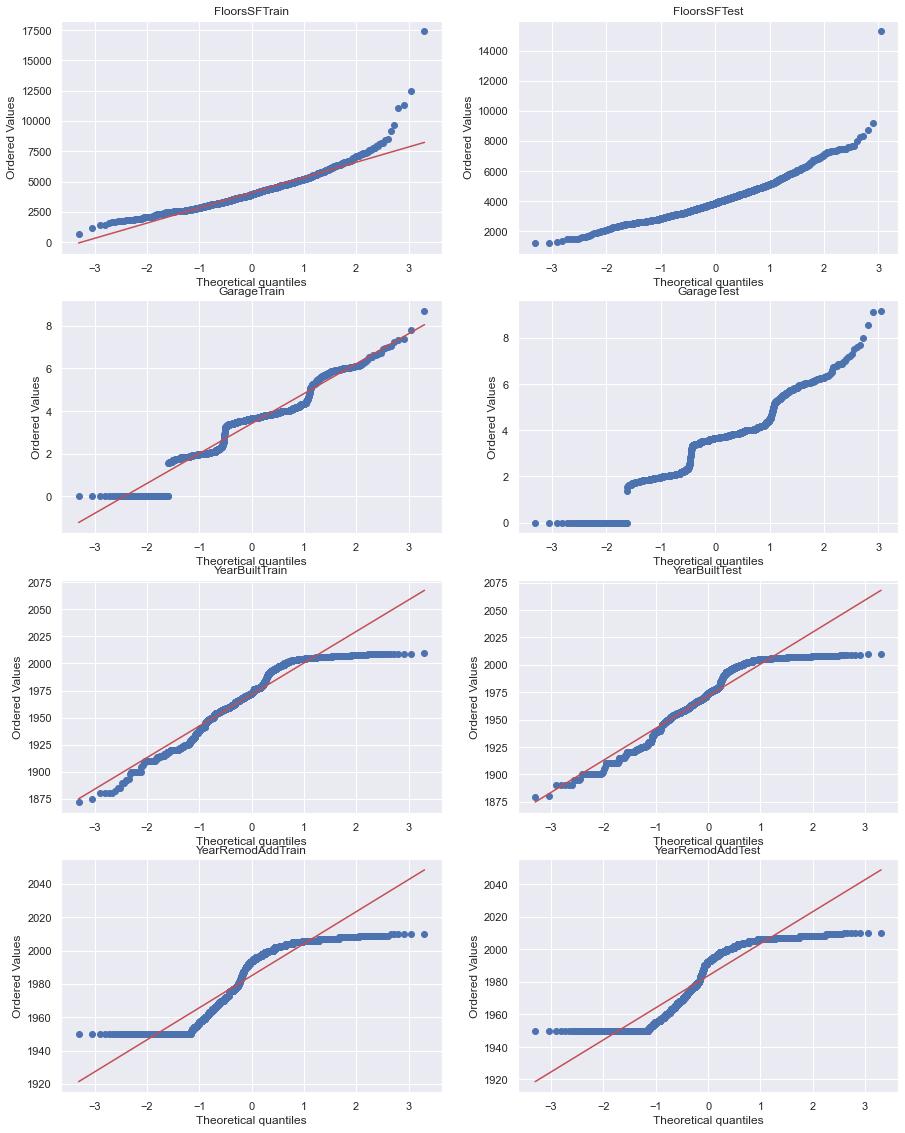

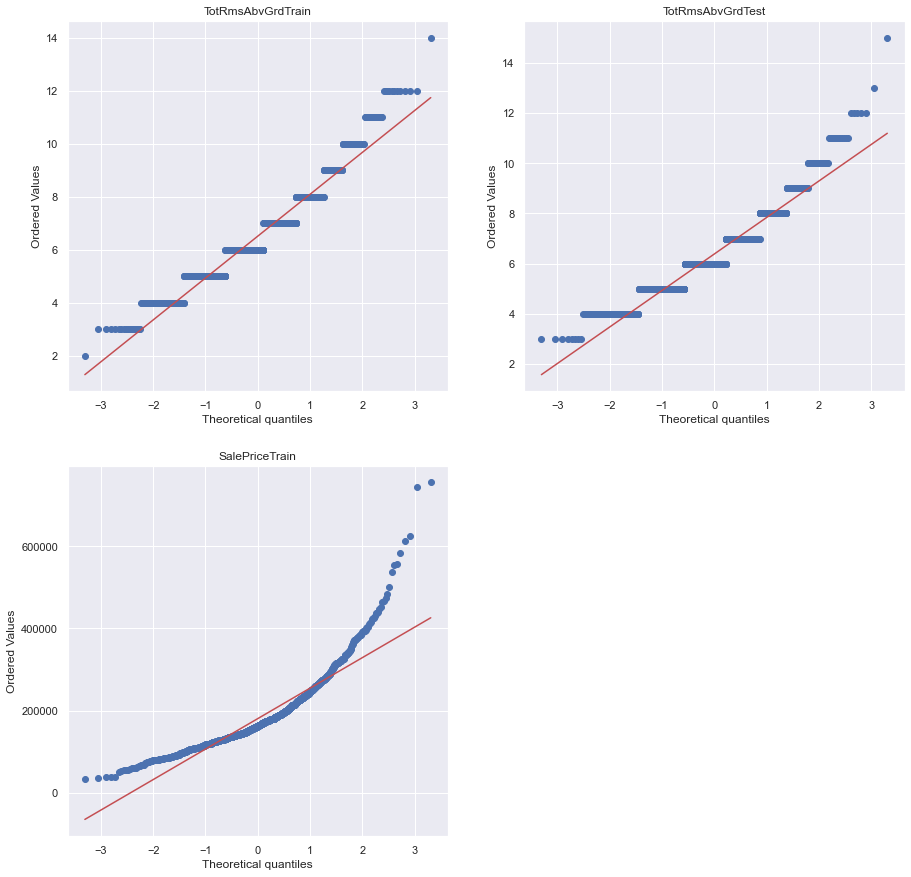

In [16]:
figa = plt.figure(figsize=(15,30))
ax1 = plt.subplot(621)
results = stats.probplot(train['FloorsSF'], plot=ax1)
ax1.set_title("FloorsSFTrain")
ax2 = plt.subplot(622)
results = stats.probplot(test['FloorsSF'], plot=ax2)
ax2.set_title("FloorsSFTest")
ax3 = plt.subplot(623)
results = stats.probplot(train['Garage'], plot=ax3)
ax3.set_title("GarageTrain")
ax4 = plt.subplot(624)
results = stats.probplot(test['Garage'], plot=ax4)
ax4.set_title("GarageTest")
ax5 = plt.subplot(625)
results = stats.probplot(train['YearBuilt'], plot=ax5)
ax5.set_title("YearBuiltTrain")
ax6 = plt.subplot(626)
results = stats.probplot(test['YearBuilt'], plot=ax6)
ax6.set_title("YearBuiltTest")
ax7 = plt.subplot(627)
results = stats.probplot(train['YearRemodAdd'], plot=ax7)
ax7.set_title("YearRemodAddTrain")
ax8= plt.subplot(628)
results = stats.probplot(test['YearRemodAdd'], plot=ax8)
ax8.set_title("YearRemodAddTest")
figb = plt.figure(figsize=(15,15))
ax1 = plt.subplot(221)
results = stats.probplot(train['TotRmsAbvGrd'], plot=ax1)
ax1.set_title("TotRmsAbvGrdTrain")
ax2 = plt.subplot(222)
results = stats.probplot(test['TotRmsAbvGrd'], plot=ax2)
ax2.set_title("TotRmsAbvGrdTest")
ax3 = plt.subplot(223)
results = stats.probplot(train['SalePrice'], plot=ax3)
ax3.set_title("SalePriceTrain")

<i><b>In the normal distribution plots above the data would align perfectly with the line, if it was normally distributed</b></i>
the distributions all deviate from the normal distribution. We also note that all values in these samples are non-negative

- there are a lot of skewed data, to normalise we can try <i>log(feature)</i>, <i>log(feature+1)</i> works better.
- for linear regression we will create dummy variables for the features which are categorical.
- We need to deal with NaN values, replace with mean of the column.

Text(0.5, 1.0, 'SalePriceTrain')

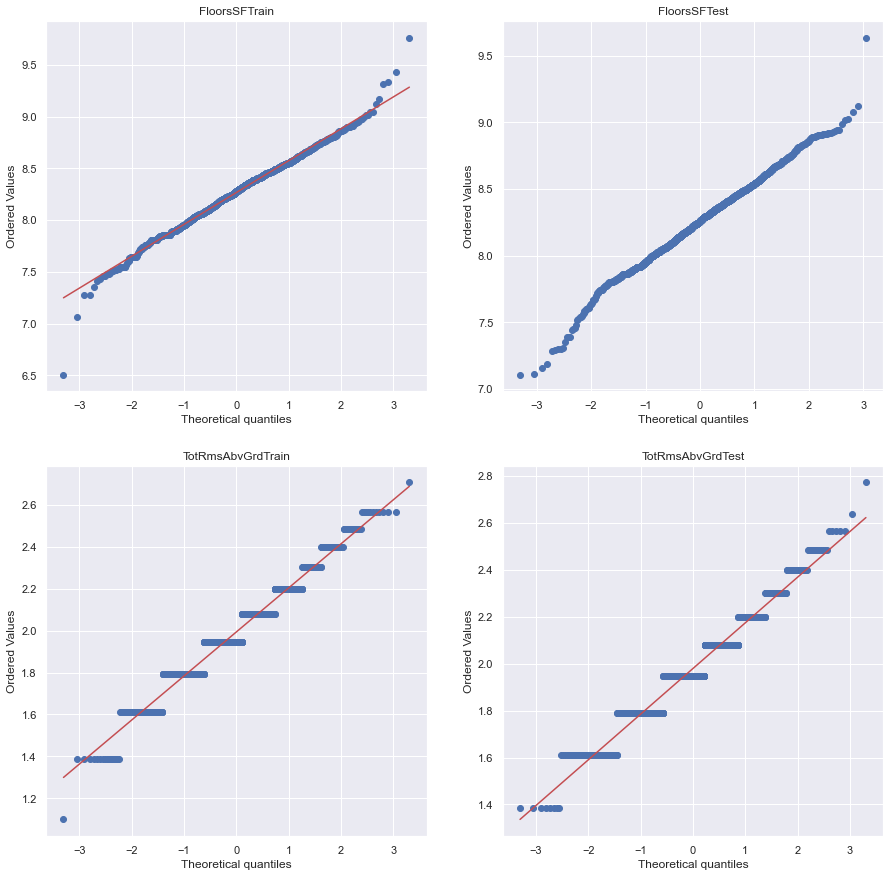

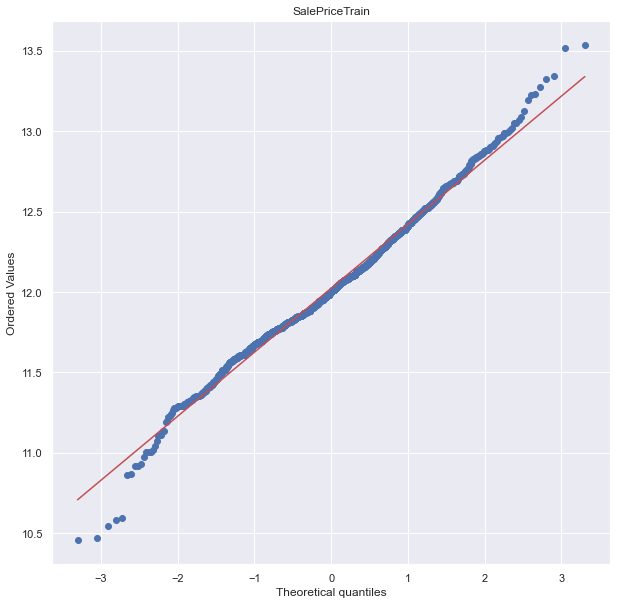

In [17]:
# data transformation by taking the logarithm
df_train = train.copy()
df_test  = test.copy()
df_train['FloorsSF'] = np.log1p(train['FloorsSF'])
df_test['FloorsSF'] = np.log1p(test['FloorsSF'])
df_train['TotRmsAbvGrd'] = np.log1p(train['TotRmsAbvGrd'])
df_test['TotRmsAbvGrd'] = np.log1p(test['TotRmsAbvGrd'])
df_train['SalePrice'] = np.log1p(train['SalePrice'])
figa = plt.figure(figsize=(15,15))
ax1 = plt.subplot(221)
results = stats.probplot(df_train['FloorsSF'], plot=ax1)
ax1.set_title("FloorsSFTrain")
ax2 = plt.subplot(222)
results = stats.probplot(df_test['FloorsSF'], plot=ax2)
ax2.set_title("FloorsSFTest")
ax3 = plt.subplot(223)
results = stats.probplot(df_train['TotRmsAbvGrd'], plot=ax3)
ax3.set_title("TotRmsAbvGrdTrain")
ax4 = plt.subplot(224)
results = stats.probplot(df_test['TotRmsAbvGrd'], plot=ax4)
ax4.set_title("TotRmsAbvGrdTest")
figc=plt.figure(figsize=(10,10))
ax4 = plt.subplot(111)
results = stats.probplot(df_train['SalePrice'], plot=ax4)
ax4.set_title("SalePriceTrain")

### Hidden Info
We create two new categorical variables based on our observations regarding SalePrice, YearBuilt and YearRemodAdd. Firstly, there seems to be a negative correlation between SalePrice and YearBuilt among old buildings and a positive correlation among young buildings. Thus, we separated the range of Year Built into two categories based on this visual observation: Built before 1920 and built after 1920. These are destinguished by the variable Centenarian. Secondly, we learned from the description file, that we can conclude that no remodelling was recorded, when YearBuilt and YearRemodAdd are identical. Hence, we try to safe this information more explicitly in the variable Remodelled

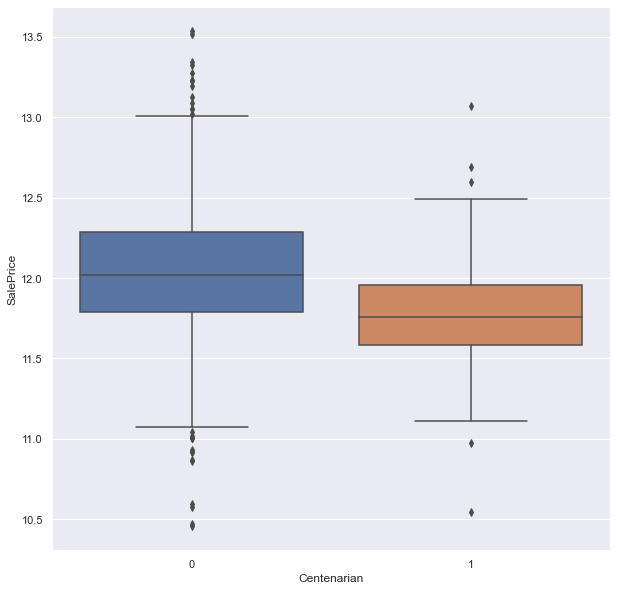

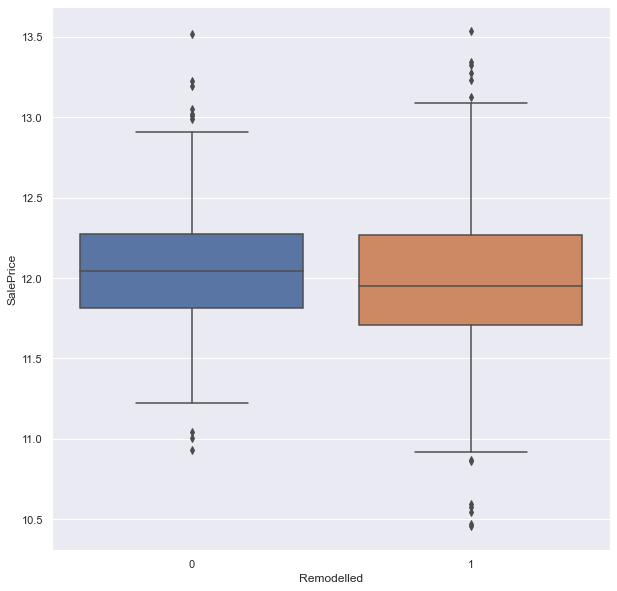

In [18]:
df_train['Centenarian']=pd.Series(len(df_train['YearBuilt']), index=df_train.index)
df_train['Centenarian']=0
df_train.loc[df_train['YearBuilt']<1920,'Centenarian']=1
df_test['Centenarian']=pd.Series(len(df_test['YearBuilt']), index=df_test.index)
df_test['Centenarian']=0
df_test.loc[df_test['YearBuilt']<1920,'Centenarian']=1
df_train['Remodelled']=pd.Series(len(df_train['YearBuilt']), index=df_train.index)
df_train['Remodelled']=0
df_train.loc[df_train['YearBuilt']!=df_train['YearRemodAdd'],'Remodelled']=1
df_test['Remodelled']=pd.Series(len(df_test['YearBuilt']), index=df_test.index)
df_test['Remodelled']=0
df_test.loc[df_test['YearBuilt']!=df_test['YearRemodAdd'],'Remodelled']=1
f1, ax1 = plt.subplots(figsize=(10, 10))
fig = sns.boxplot(x='Centenarian', y="SalePrice", data=df_train)
f3, ax3 = plt.subplots(figsize=(10, 10))
fig = sns.boxplot(x='Remodelled', y="SalePrice", data=df_train)

We can use the new variable Centenarian, to check whether splitting up the time range of YearBuilt can help to improve correlation with the SalePrice. If this is transferable to the test set, it could help us to generate better predictions:

In [19]:
data = pd.concat([df_train['SalePrice'], df_train['YearBuilt']], axis=1)
for i in range(2):
    if i <1:
        print('Among Centenarians')
        dat = data.loc[df_train['YearBuilt']<1920]
    else:
        print('Among younger buildings')
        dat = data.loc[df_train['YearBuilt']>=1920]
    corrmat=dat.corr()
    cols = corrmat.index
    cm = np.corrcoef(dat[cols].values.T) # accessing the correlation coefficients to depict them as numbers
    print('The correlation coefficient between SalePrice and YearBuilt is:')
    print(cm[0,1])

Among Centenarians
The correlation coefficient between SalePrice and YearBuilt is:
-0.09170207173947248
Among younger buildings
The correlation coefficient between SalePrice and YearBuilt is:
0.6258591144467363


## Findings
While the SalePrice is slightly negatively correlated to the age among centenarians, It is positively correlated to the SalePrice among younger buildings. The new variable Centenarian can help us to distinguish these two cases. We can now try to build a model that effectively combines the information that is contained in the cleaned datasets:

### Going to the simple approach

As discussed earlier we will now follow a simpler approach to transform the Data.

In [20]:
train = pd.read_csv("dataSet/train.csv")
test = pd.read_csv("dataSet/test.csv")

In [21]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'log(price + 1)'}>]], dtype=object)

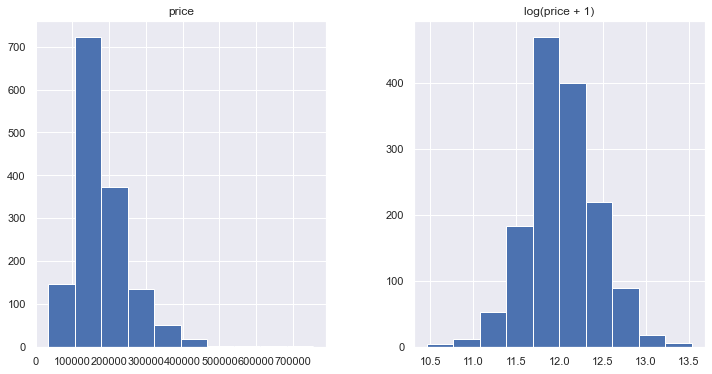

In [22]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [23]:
# We will now transform the target variable as we know now that the ransformation works
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform all the skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

#computing skewness and thiss will be interesting considering the previous techniques
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) 
skewed_feats = skewed_feats[skewed_feats > 0.75] # 75% is alway a good threshold right?
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [24]:
all_data = pd.get_dummies(all_data)

In [25]:
# Following the second path of taking the mean
all_data = all_data.fillna(all_data.mean())

### Wait
<br>At this point we will create four (4) dataFrames
* One set using the complex method we followed from the start
  - C_train and C_test
 
* Another set using the simple approach above
  - X_train and X_test
  
<hr>
<b> y will reamin the same for both since we are essentially predicting the SalePrice

In [26]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]

In [27]:
df_test = df_test.fillna(df_test.mean())
df_train = pd.get_dummies(df_train)

C_test = pd.get_dummies(df_test)

cols = list(df_train.columns)
cols.remove('SalePrice')

C_train = df_train[cols]

#### Data Clearity
Here we now have two different types of data
1. Highly transformed data which is related to SalePrice
2. Slightly transformed data which is taken as is

<hr>To clearly observe

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Columns: 288 entries, MSSubClass to SaleCondition_Partial
dtypes: float64(25), int64(11), uint8(252)
memory usage: 781.3 KB


In [29]:
C_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 151 entries, Id to SaleCondition_Partial
dtypes: float64(3), int64(29), uint8(119)
memory usage: 534.8 KB


looking at the columns we can see that the no. of variables are different.

We will now refer to Related dataframe i.e. <b>C_train, C_test as D1</b>
and refer to raw dataframe i.e. <b>X_train, X_test as D2</b>

In [30]:
y = df_train.SalePrice

### Lights, Camera aannndd... Models
We are going to try few different regression techniques

we shall start with observing Root-Mean-Squared-Error or RMSE

In [31]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [32]:
# We will check for both the cases because why not?

def rmse_cv1(model):
    rmse = np.sqrt(-cross_val_score(model, C_train, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

def rmse_cv2(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


In [33]:
model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge1 = [rmse_cv1(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

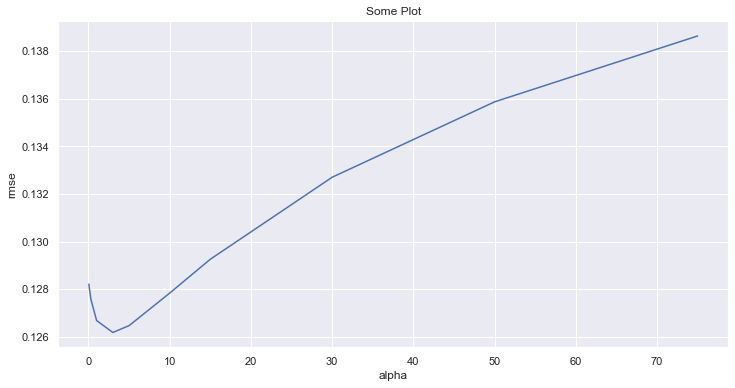

In [34]:
cv_ridge1 = pd.Series(cv_ridge1, index = alphas)
cv_ridge1.plot(title = "Some Plot")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [35]:
cv_ridge1.min()

0.12617263187078342

In [36]:
cv_ridge2 = [rmse_cv2(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

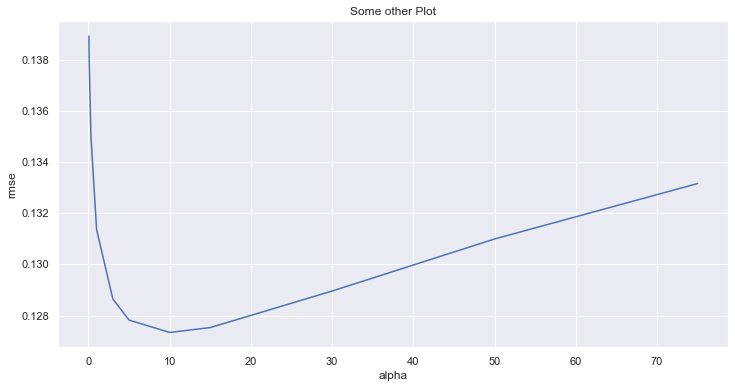

In [37]:
cv_ridge2 = pd.Series(cv_ridge2, index = alphas)
cv_ridge2.plot(title = "Some other Plot")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [38]:
cv_ridge2.min()

0.12733734668670751

#### Ridge RMSE
we have two rmse for the two ridge models
1. 0.1261 for D1
2. 0.1273 for D2

We will now move on to the <b>Lasso CV</b> to the figure out the alpha.
Apparently the alpha in Lasso CV are inverse of the alphas in Ridge.

In [39]:
model_lasso1 = LassoCV(alphas = [1, 0.5, 0.1, 0.005, 0.001, 0.0005]).fit(C_train, y)
rmse_cv1(model_lasso1).mean()

0.12400088906131805

In [40]:
model_lasso2 = LassoCV(alphas = [1, 0.5, 0.1, 0.005, 0.001, 0.0005]).fit(X_train, y)
rmse_cv2(model_lasso2).mean()

0.1225673588504814

Lasso performs better than Ridge on the given data but the difference between D1 and D2 is quite opposite from what we saw before.
1. 0.124 for D1
2. 0.122 for D2
On a different note: The Lasso does feature selection for you - setting coefficients of features it deems unimportant to zero. Let's take a look at the coefficients:

In [41]:
coef1 = pd.Series(model_lasso1.coef_, index = C_train.columns)
coef2 = pd.Series(model_lasso2.coef_, index = X_train.columns)

In [42]:
print("For D1 Lasso picked " + str(sum(coef1 != 0)) + " variables and eliminated the other " +  str(sum(coef1 == 0)) + " variables")

print("For D2 Lasso picked " + str(sum(coef2 != 0)) + " variables and eliminated the other " +  str(sum(coef2 == 0)) + " variables")

For D1 Lasso picked 76 variables and eliminated the other 75 variables
For D2 Lasso picked 110 variables and eliminated the other 178 variables


Text(0.5, 1.0, 'Coefficients in the model for D1')

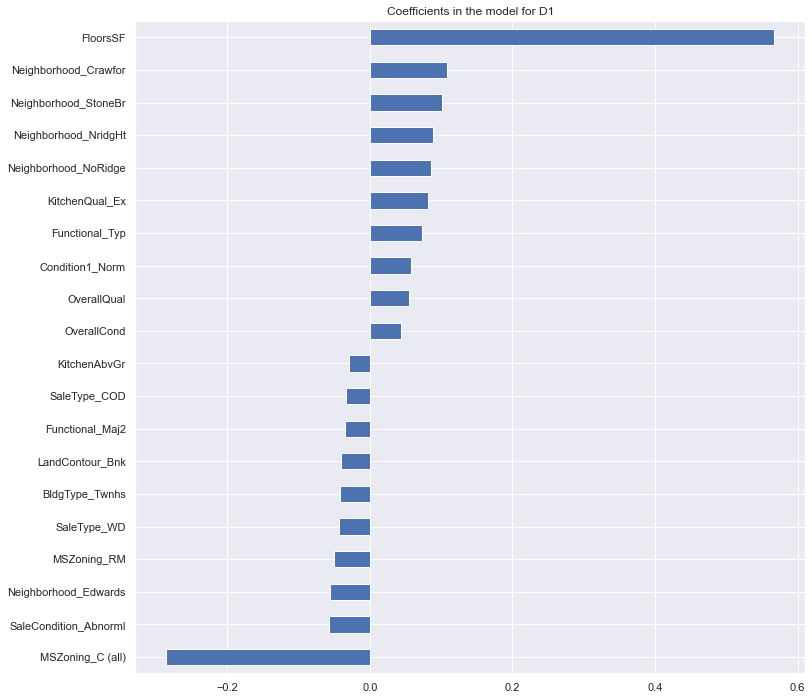

In [43]:
imp_coef1 = pd.concat([coef1.sort_values().head(10),
                     coef1.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
imp_coef1.plot(kind = "barh")
plt.title("Coefficients in the model for D1")

Text(0.5, 1.0, 'Coefficients in the model for D2')

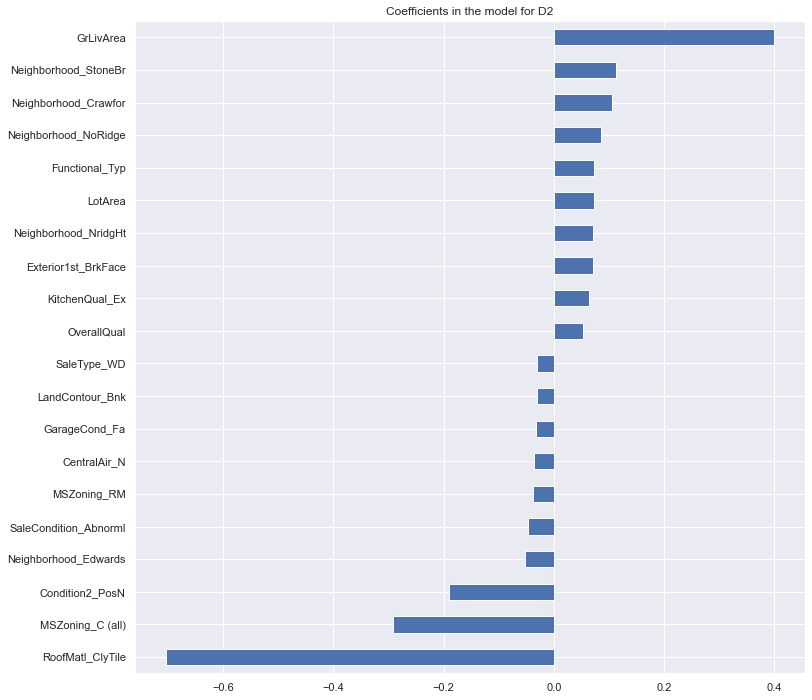

In [44]:
imp_coef2 = pd.concat([coef2.sort_values().head(10),
                     coef2.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)
imp_coef2.plot(kind = "barh")
plt.title("Coefficients in the model for D2")

### More observations
As expected the results from the two graphs aboe are quite dufferent.
1. For D1 the new variable we made `FloorSF` seems like quite a big success
2. For D2 `GrLivArea`-the above ground area by area square feet seems most important.
3. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

<hr>
Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='preds', ylabel='residuals'>

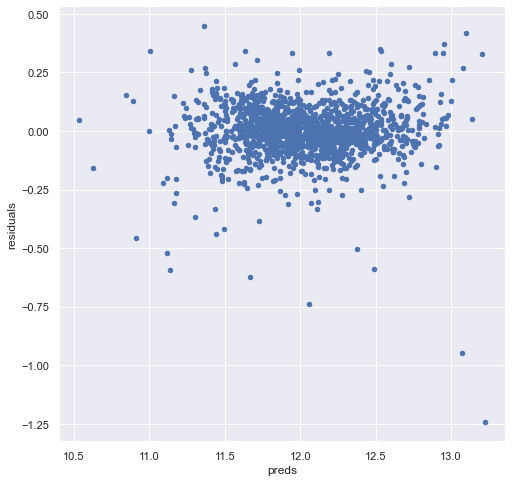

In [45]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

preds1 = pd.DataFrame({"preds":model_lasso1.predict(C_train), "true":y})
preds1["residuals"] = preds1["true"] - preds1["preds"]
preds1.plot(x = "preds", y = "residuals", kind = "scatter")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='preds', ylabel='residuals'>

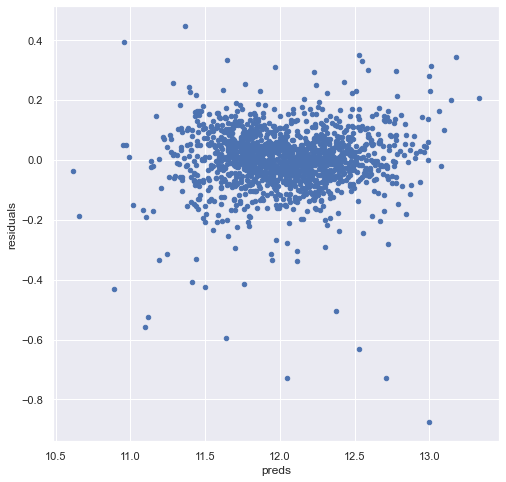

In [46]:
#let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

preds2 = pd.DataFrame({"preds":model_lasso2.predict(X_train), "true":y})
preds2["residuals"] = preds2["true"] - preds2["preds"]
preds2.plot(x = "preds", y = "residuals",kind = "scatter")

### Adding more Models:
Let's add an xgboost model to our linear model to see if we can improve our score:

In [47]:
import xgboost as xgb

In [48]:
dtrain1 = xgb.DMatrix(C_train, label = y)
dtest1 = xgb.DMatrix(C_test)

params = {"max_depth":2, "eta":0.1}
model1 = xgb.cv(params, dtrain1, num_boost_round = 500, early_stopping_rounds = 150)

<AxesSubplot:>

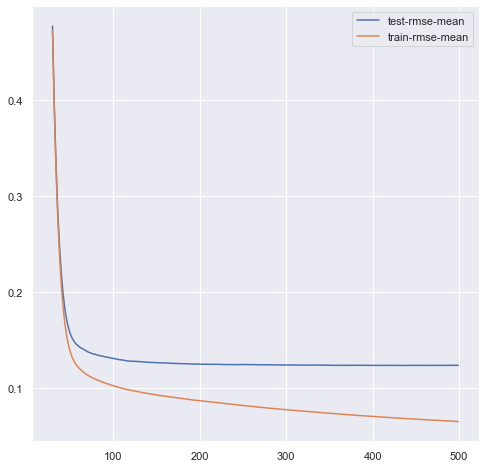

In [49]:
model1.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [50]:
model_xgb1 = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1)
model_xgb1.fit(C_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
xgb_preds1 = np.expm1(model_xgb1.predict(C_test))
lasso_preds1 = np.expm1(model_lasso1.predict(C_test))

c:\users\aksha\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='xgb', ylabel='lasso'>

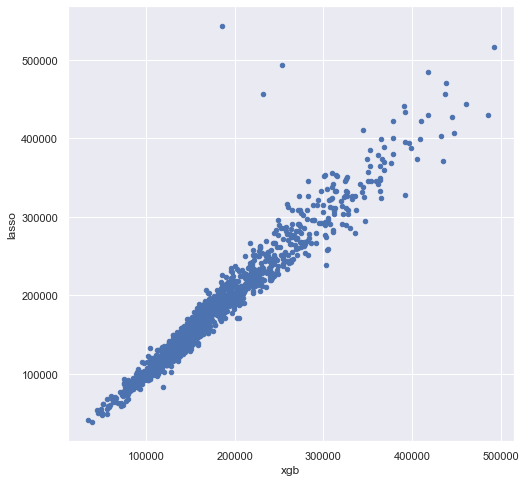

In [52]:
predictions1 = pd.DataFrame({"xgb":xgb_preds1, "lasso":lasso_preds1})
predictions1.plot(x = "xgb", y = "lasso", kind = "scatter")

In [53]:
preds1 = 0.7*lasso_preds1 + 0.3*xgb_preds1
solution1 = pd.DataFrame({"id":test.Id, "SalePrice":preds1})
solution1.to_csv("ridge_sol_D1.csv", index = False)

In [54]:
dtrain2 = xgb.DMatrix(X_train, label = y)
dtest2 = xgb.DMatrix(X_test)

model2 = xgb.cv(params, dtrain2, num_boost_round = 500, early_stopping_rounds = 150)

<AxesSubplot:>

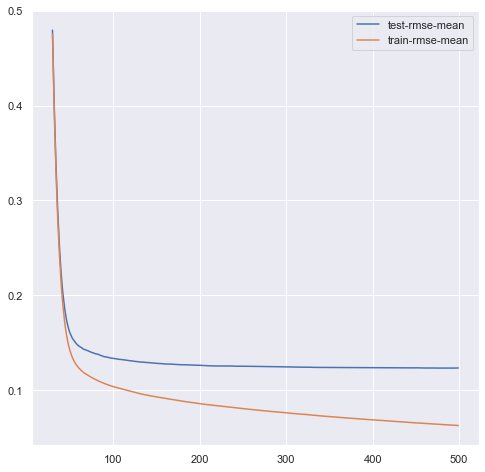

In [55]:
model2.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [56]:
model_xgb2 = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = 0.1)
model_xgb2.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=360, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
xgb_preds2 = np.expm1(model_xgb2.predict(X_test))
lasso_preds2 = np.expm1(model_lasso2.predict(X_test))

c:\users\aksha\appdata\local\programs\python\python39\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='xgb', ylabel='lasso'>

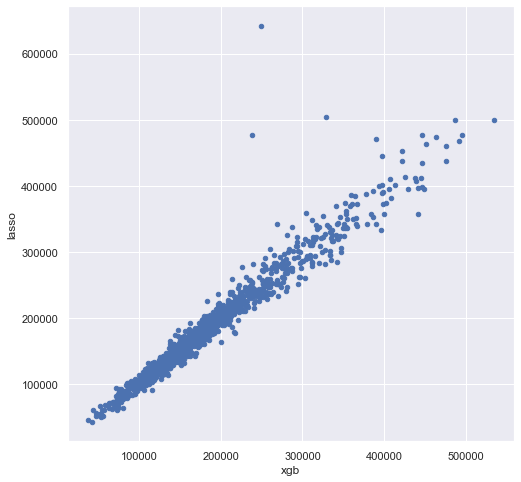

In [58]:
predictions2 = pd.DataFrame({"xgb":xgb_preds2, "lasso":lasso_preds2})
predictions2.plot(x = "xgb", y = "lasso", kind = "scatter")

In [59]:
preds2 = 0.7*lasso_preds2 + 0.3*xgb_preds2
solution2 = pd.DataFrame({"id":test.Id, "SalePrice":preds2})
solution2.to_csv("ridge_sol_D2.csv", index = False)

## Keras !!!!!
Let's try keras fro the sake of it

In [60]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [61]:
X_train = StandardScaler().fit_transform(X_train)
C_train = StandardScaler().fit_transform(C_train)

In [62]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 2)
C_tr, C_val, b_tr, b_val = train_test_split(C_train, y, random_state = 2)

In [63]:
X_tr.shape

(1095, 288)

In [64]:
C_tr.shape

(1095, 151)

In [65]:
model1 = Sequential()
#model.add(Dense(256, activation="relu", input_dim = X_train.shape[1]))
model1.add(Dense(1, input_dim = C_train.shape[1], kernel_regularizer=l1(0.001)))

model1.compile(loss = "mse", optimizer = "adam")

In [66]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 152       
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [67]:
hist1 = model1.fit(C_tr, b_tr, validation_data = (C_val, b_val))

35/35 [==============================] - 16s 13ms/step - loss: 147.0823 - val_loss: 145.4570


<AxesSubplot:>

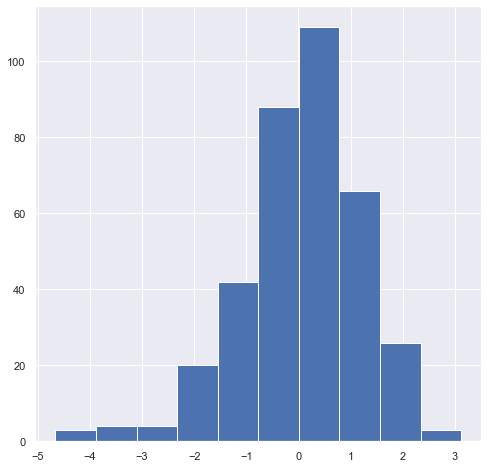

In [68]:
pd.Series(model1.predict(C_val)[:,0]).hist()

I think this is as far as we could go. This was one awesome adventure.
### Thank you
I was inpired to do this projects as I encountered this [kaggle comp](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

I learned most of the techniques from Alexandru Papiui's [@apapiu](https://www.kaggle.com/apapiu/regularized-linear-models/notebook) notebook.